In [ ]:
# При первом запуске необходимо незакомменченные пипы заинстоллить
!pip install --no-cache-dir --upgrade git+https://github.com/ai-forever/Kandinsky-2.0.git

In [ ]:
!pip install torch-optimizer

In [ ]:
#!pip install --no-cache-dir --upgrade horovod 

In [ ]:
!pip install --no-cache-dir --upgrade git+https://github.com/openai/CLIP.git

In [ ]:
!pip install --upgrade setuptools

In [1]:
from kandinsky2.model.model_creation import create_model, create_gaussian_diffusion
from transformers import AutoTokenizer
from PIL import Image
import cv2
import torch
from omegaconf import OmegaConf
import math
from kandinsky2.model.text_encoders import TextEncoder
from kandinsky2.vqgan.autoencoder import VQModelInterface, AutoencoderKL
from copy import deepcopy
import torch.nn.functional as F
import numpy as np
from kandinsky2.utils import prepare_image, q_sample, process_images, prepare_mask
import pytorch_lightning as pl
import torch
from torch import nn
from abc import ABC, abstractmethod
import functools
from kandinsky2 import get_kandinsky2
from kandinsky2 import CONFIG_2_0 as CONFIG

from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint_sequential
from torch.cuda.amp import autocast
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from transformers import Adafactor
import transformers
import pandas as pd
from tqdm import tqdm

/home/user/conda/envs/test_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from torch import __version__

In [28]:
__version__

'1.13.1+cu117'

In [72]:
CSV_PATH = "datasets/tags_princess_mononoke.xlsx"
DEVICE = 'cuda'
IMAGES_FOLDER = 'datasets/princess_mononoke'
CHECKPOINT_PATH = "checkpoints2/laputa_castle_2.pt"
SAVE_PATH = 'checkpoints2/princess_mononoke_2.pt'

# Preprocess if needed

In [73]:
excel = pd.read_excel(CSV_PATH)
excel

,image_name,tagger1_result,id_tagger_1,tagger2_result,id_tagger_2
0,000661.jpg,Человек в синей рубахе с луком в руках скачет ...,e19e3da6-eb8b-4349-a05b-09f1189369a6,"антилопа с большими витиеватыми рогами, у нее...",aceaab0c-a61c-4a77-834b-d977b71d47dc
1,000176.jpg,"Тропинка, которая тянется вдоль водоема и веде...",e19e3da6-eb8b-4349-a05b-09f1189369a6,Трое человек в кимоно идет по тропинке на фоне...,87bd59eb-e43c-4932-b406-7a29cd17218d
2,000161.jpg,"Мужчина несет связку бамбука на плече, мужчина...",87bd59eb-e43c-4932-b406-7a29cd17218d,Девушка в розовом кимоно с белым платком на во...,ff3e80f4-b8d8-4e96-8b21-62abf9a3a1a3
3,000330.jpg,Пять женщин в кимоно и головных уборах с банта...,87bd59eb-e43c-4932-b406-7a29cd17218d,Девушки с платками на голове и в кимоно прыгаю...,e19e3da6-eb8b-4349-a05b-09f1189369a6
4,000763.jpg,девочка с красными рисунками на лице в белой о...,aceaab0c-a61c-4a77-834b-d977b71d47dc,"Девочка с украшение на голове, с красными рису...",87bd59eb-e43c-4932-b406-7a29cd17218d
...,...,...,...,...,...
894,000702.jpg,Стадо кабанов идут по полю в сторону большой с...,87bd59eb-e43c-4932-b406-7a29cd17218d,высокие каменные горы с маленькими красными зо...,aceaab0c-a61c-4a77-834b-d977b71d47dc
895,000075.jpg,девушки в шляпах с красным конусом смотрят в о...,f5afd72a-c0ef-4451-8b7f-e917a2e3a15e,"Три девочки в синих кимоно и в широкополых, со...",ff3e80f4-b8d8-4e96-8b21-62abf9a3a1a3
896,000857.jpg,берег реки и летающий в небе мусор на фоне гол...,aceaab0c-a61c-4a77-834b-d977b71d47dc,Вода на фоне высоких гор,87bd59eb-e43c-4932-b406-7a29cd17218d
897,000135.jpg,человек в красной шапке и синей одежде с мехов...,aceaab0c-a61c-4a77-834b-d977b71d47dc,Темноволосый юноша в красном капюшоне с белыми...,ff3e80f4-b8d8-4e96-8b21-62abf9a3a1a3


In [74]:
df = pd.DataFrame()
df['text'] = excel['tagger1_result']
df['path'] = excel['image_name']
df

,text,path
0,Человек в синей рубахе с луком в руках скачет ...,000661.jpg
1,"Тропинка, которая тянется вдоль водоема и веде...",000176.jpg
2,"Мужчина несет связку бамбука на плече, мужчина...",000161.jpg
3,Пять женщин в кимоно и головных уборах с банта...,000330.jpg
4,девочка с красными рисунками на лице в белой о...,000763.jpg
...,...,...
894,Стадо кабанов идут по полю в сторону большой с...,000702.jpg
895,девушки в шляпах с красным конусом смотрят в о...,000075.jpg
896,берег реки и летающий в небе мусор на фоне гол...,000857.jpg
897,человек в красной шапке и синей одежде с мехов...,000135.jpg


In [75]:
df = pd.DataFrame()
df['text'] = excel['tagger2_result']+ ' в стиле Хаяо Миядзаки'
df['path'] = excel['image_name']
df

,text,path
0,"антилопа с большими витиеватыми рогами, у нее...",000661.jpg
1,Трое человек в кимоно идет по тропинке на фоне...,000176.jpg
2,Девушка в розовом кимоно с белым платком на во...,000161.jpg
3,Девушки с платками на голове и в кимоно прыгаю...,000330.jpg
4,"Девочка с украшение на голове, с красными рису...",000763.jpg
...,...,...
894,высокие каменные горы с маленькими красными зо...,000702.jpg
895,"Три девочки в синих кимоно и в широкополых, со...",000075.jpg
896,Вода на фоне высоких гор в стиле Хаяо Миядзаки,000857.jpg
897,Темноволосый юноша в красном капюшоне с белыми...,000135.jpg


In [7]:
# df = pd.read_csv(CSV_PATH)
# df.head()

# Initializing classes

In [8]:
def center_crop(image):
    width, height = image.size
    new_size = min(width, height)
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2
    return image.crop((left, top, right, bottom))
class kandinsky2Dataset(Dataset):
    
    def __init__(self, df, folder):
        self.tokenizer1 = AutoTokenizer.from_pretrained('M-CLIP/XLM-Roberta-Large-Vit-B-16Plus')
        self.tokenizer2 = AutoTokenizer.from_pretrained('google/mt5-small')
        self.df = df
        self.folder = folder
    
    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, item):
        img_name = self.df['path'].iloc[item]
        image = center_crop(Image.open(f'{self.folder}/{img_name}'))
        image = image.resize((512, 512), resample=Image.BICUBIC, reducing_gap=1) # was 640
        arr = np.array(image.convert("RGB"))
        arr = arr.astype(np.float32) / 127.5 - 1
        text = self.df['text'].iloc[item]
        if np.random.binomial(1, 0.1):
            text = ''
        text_encoding1 = self.tokenizer1(
                text,
                max_length=77,
                padding="max_length",
                truncation=True,
                return_attention_mask=True,
                add_special_tokens=True,
                return_tensors="pt")

        tokens1 = text_encoding1['input_ids'][0]
        mask1 = text_encoding1['attention_mask'][0]
        text_encoding2 = self.tokenizer2(
                text,
                max_length=77,
                padding="max_length",
                truncation=True,
                return_attention_mask=True,
                add_special_tokens=True,
                return_tensors="pt")

        tokens2 = text_encoding2['input_ids'][0]
        mask2 = text_encoding2['attention_mask'][0]
        
        return np.transpose(arr, [2, 0, 1]), tokens1, mask1, tokens2, mask2



In [9]:
class ScheduleSampler(ABC):
    """
    A distribution over timesteps in the diffusion process, intended to reduce
    variance of the objective.
    By default, samplers perform unbiased importance sampling, in which the
    objective's mean is unchanged.
    However, subclasses may override sample() to change how the resampled
    terms are reweighted, allowing for actual changes in the objective.
    """

    @abstractmethod
    def weights(self):
        """
        Get a numpy array of weights, one per diffusion step.
        The weights needn't be normalized, but must be positive.
        """

    def sample(self, batch_size, device):
        """
        Importance-sample timesteps for a batch.
        :param batch_size: the number of timesteps.
        :param device: the torch device to save to.
        :return: a tuple (timesteps, weights):
                 - timesteps: a tensor of timestep indices.
                 - weights: a tensor of weights to scale the resulting losses.
        """
        w = self.weights()
        p = w / np.sum(w)
        indices_np = np.random.choice(len(p), size=(batch_size,), p=p)
        indices = torch.from_numpy(indices_np).long().to(device)
        weights_np = 1 / (len(p) * p[indices_np])
        weights = torch.from_numpy(weights_np).float().to(device)
        return indices, weights


class UniformSampler(ScheduleSampler):
    def __init__(self, diffusion):
        self.diffusion = diffusion
        self._weights = np.ones([diffusion.num_timesteps])

    def weights(self):
        return self._weights


class Kandinsky2(nn.Module):
    def __init__(self, config,):
        super().__init__()
        self.config = config
        self.config['model_config']['up'] = False
        self.config['model_config']['inpainting'] = False
        self.config['model_config']['use_fp16'] = False
        self.config['model_config']['cache_text_emb'] = False
        model = get_kandinsky2('cpu', task_type='text2img', model_version='2.0')
        self.text_encoder1 = model.text_encoder1
        self.text_encoder2 = model.text_encoder2
        self.use_image_enc = True
        self.scale = self.config['image_enc_params']['scale']
        self.image_encoder = model.image_encoder
        
        
        self.model = model.model
        self.diffusion = create_gaussian_diffusion(**config['diffusion_config'])
        self.schedule_sampler = UniformSampler(self.diffusion)
        model = None
    @torch.no_grad()
    def encode_text(self, text_encoder, input_ids, attention_mask):
        full_emb, pooled_emb = text_encoder(tokens=input_ids, mask=attention_mask)
        return full_emb, pooled_emb

    def model_step(self, batch, device):
        image, tokens_clip, mask_clip, tokens_t5, mask_t5 = batch
        image, tokens_clip, mask_clip, tokens_t5, mask_t5 = image.to(device), tokens_clip.to(device), mask_clip.to(device), tokens_t5.to(device), mask_t5.to(device)
        with torch.no_grad():
            image = self.image_encoder.encode(image).sample()
            image = image * self.scale
        with torch.no_grad():
            full_emb1, pooled_emb1 = self.encode_text(text_encoder=self.text_encoder1, input_ids=tokens_clip, attention_mask=mask_clip)
            full_emb2, pooled_emb2 = self.encode_text(text_encoder=self.text_encoder2, input_ids=tokens_t5, attention_mask=mask_t5)
        cond = {'full_emb1': full_emb1, 'full_emb2': full_emb2, 'pooled_emb1': pooled_emb1, 'pooled_emb2': pooled_emb2}
        t, weights = self.schedule_sampler.sample(image.shape[0], image.device)
        compute_losses = functools.partial(
            self.diffusion.training_losses,
            self.model,
            image,
            t,
            model_kwargs=cond,
        )
        losses = compute_losses()
        loss = losses["loss"].mean()
        return loss

In [76]:
dataset = kandinsky2Dataset(df, IMAGES_FOLDER)
train_data = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=True)

/home/jovyan/.imgenv-tune-kand-4gpu-0/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [11]:
model = Kandinsky2(CONFIG,).to(DEVICE)

/home/jovyan/.imgenv-tune-kand-4gpu-0/lib/python3.7/site-packages/huggingface_hub/file_download.py:642: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,
Some weights of the model checkpoint at /tmp/kandinsky2/2_0/text_encoder2 were not used when initializing MT5EncoderModel: ['decoder.final_layer_norm.weight', 'decoder.block.3.layer.2.DenseReluDense.wo.weight', 'decoder.block.4.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.6.layer.1.EncDecAttention.o.weight', 'decoder.block.6.layer.0.SelfAttention.o.weight', 'decoder.block.4.layer.0.SelfAttention.o.weight', 'decoder.block.5.layer.0.SelfAttention.v.weight', 'decoder.block.4.layer.0.layer_norm.weight', 'decoder.block.5.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.3.layer.0.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /tmp/kandinsky2/2_0/vae.ckpt


In [12]:
model.text_encoder1.requires_grad_=True
model.text_encoder2.requires_grad_=True

In [13]:
model.model.requires_grad_=True

In [14]:
params = torch.nn.ModuleList([model.text_encoder2,model.text_encoder1,model.model])

In [77]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))

<All keys matched successfully>

In [78]:
epochs = 100

In [39]:
import torch_optimizer as optim
optimizer = optim.NovoGrad(
    params.parameters(),
    lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,
)
#optimizer = torch.optim.Adam(, lr=1e-3)#, scale_parameter=False, relative_step=False)
lr_scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(len(train_data)*epochs * 0.3), num_training_steps=len(train_data)*epochs)

In [40]:
# !mkdir checkpoints2

In [41]:
# !mkdir logs

In [42]:
#import wandb
#wandb.init(project = 'kandi tune', entity = "alexwortega")

In [23]:
args ={"save_every":1000}

In [69]:
from IPython.display import clear_output

# Training loop

In [79]:
save_counter = 0
import os
for epoch in range(epochs):
    clear_output(wait=True)

    print(f'epoch {epoch+1}/{epochs}')
    for batch in tqdm(train_data):
        save_counter+=1
        optimizer.zero_grad()
        loss = model.model_step(batch, DEVICE)
#         print('loss =', loss.item())
        optimizer.step()
#         wandb.log({"loss":  loss.item()})
        lr_scheduler.step()
    
#     if epoch > 0:
#         os.remove("checkpoints2/kandi_icones.pt") 
    torch.save(
                        model.state_dict(),
                        SAVE_PATH
                        )
    
    clear_output(wait=True)

epoch 100/100


100%|██████████| 449/449 [01:13<00:00,  6.09it/s]


In [ ]:
torch.save(model.state_dict(), SAVE_PATH)

In [ ]:
# torch.save(model.state_dict(), 'test.pt')

In [2]:
#30 эпох отработал, завис, но не умер
#еще 38
#28


Signature:
 get_kandinsky2(
    device,
    task_type='text2img',
    cache_dir='/tmp/kandinsky2',
    use_auth_token=None,
)
Docstring: <no docstring>
File:      ~/.imgenv-tune-kandinsky-0/lib/python3.7/site-packages/kandinsky2/__init__.py
Type:      function


# Тестим

## До

In [5]:
model_1 = get_kandinsky2("cuda", cache_dir="tmp/kand2", task_type='text2img', model_version='2.1')

/home/jovyan/.imgenv-kand21-training-0/lib/python3.7/site-packages/huggingface_hub/file_download.py:637: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(

ConnectionError: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out.

In [29]:
images = model_1.generate_text2img('Иконка поезда', batch_size=4, 
                                 h=512, w=512, num_steps=75, denoised_type='dynamic_threshold',
                                 dynamic_threshold_v=99.5, sampler='ddim_sampler', ddim_eta=0.05, guidance_scale=10)

NameError: name 'model_1' is not defined

In [30]:
images[0]

NameError: name 'images' is not defined

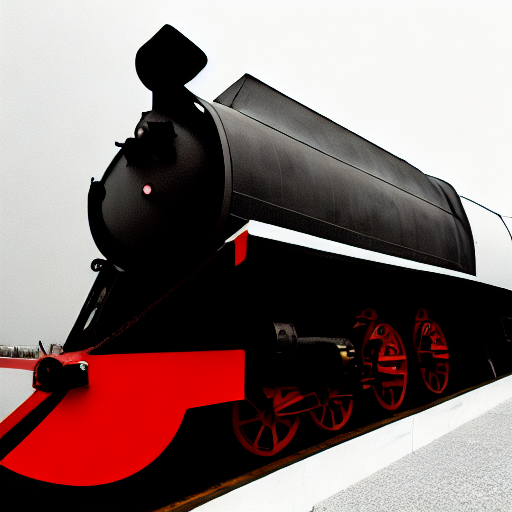

In [5]:
images[1]

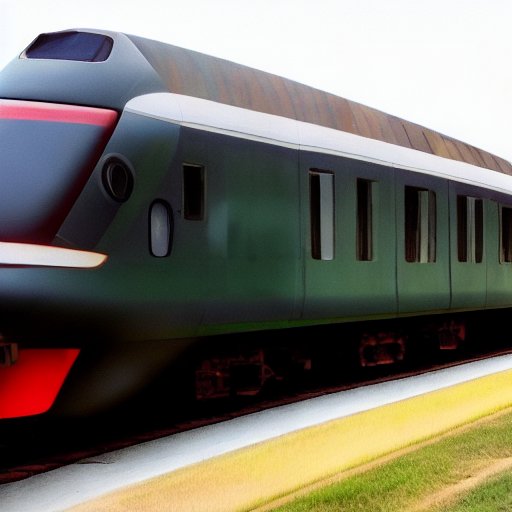

In [6]:
images[2]

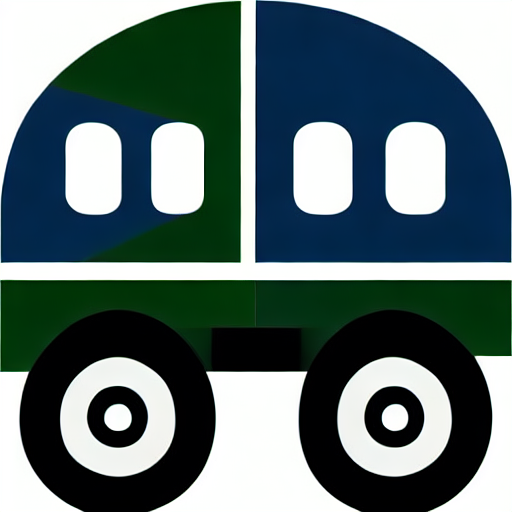

In [7]:
images[3]